In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None)

df_fake = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
df_real = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')

In [3]:
df_fake['fake'] = 1
df_real['fake'] = 0

df_fake.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known be

In [4]:
from sklearn.utils import shuffle
df = pd.concat([df_fake, df_real], axis=0)

# Shuffle the data
df = shuffle(df).reset_index(drop=True)
df.head()

title  \
0                                                   History Channel Classification Of The 2016 Election Makes Trump Supporters Lose Their Sh*t   
1  WOW! VIDEO EMERGES Of Hillary Clinton Admitting Foreign Leaders Contacted Her During Campaign, Discussed How They Could “Stop Donald Trump”   
2                                                       TOP OBAMA OFFICIAL: We Find Illegal Aliens But Here’s Why We Don’t Deport Them [Video]   
3           #NFL TWEETS About Tom Brady’s Deflategate Appeal Denial…IGNORES Isaiah Crowell’s Image Of Cop’s Throat Being Slit On Social Media?   
4                                                                        Clinton Just Expertly Trolled Trump With This Very Special Calculator   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['fake'],axis=1), df['fake'], test_size=0.2, random_state=0)

In [6]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.config.num_labels = 1

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
# Freeze the pre trained parameters
for param in model.parameters():
    param.requires_grad = False

# Add three new layers at the end of the network
model.classifier = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
    nn.Softmax(dim=1)
)

model = model.to(device)

In [9]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [10]:
def preprocess_text(text):
    parts = []

    text_len = len(text.split(' '))
    delta = 300
    max_parts = 5
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
        
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

In [11]:
train_data = pd.concat([X_train, y_train], axis=1).reset_index()

print_every = 300

total_loss = 0
all_losses = []

CUDA_LAUNCH_BLOCKING=1

model.train()

for idx, row in train_data.iterrows():
    text_parts = preprocess_text(str(row['text']))
    label = torch.tensor([row['fake']]).long().to(device)

    optimizer.zero_grad()

    overall_output = torch.zeros((1, 2)).float().to(device)
    for part in text_parts:
        if len(part) > 0:
            try:
                input = part.reshape(-1)[:512].reshape(1, -1)
                # print(input.shape)
                overall_output += model(input, labels=label)[1].float().to(device)
            except Exception as e:
                print(str(e))

#     overall_output /= len(text_parts)
    overall_output = F.softmax(overall_output[0], dim=-1)

    if label == 0:
        label = torch.tensor([1.0, 0.0]).float().to(device)
    elif label == 1:
        label = torch.tensor([0.0, 1.0]).float().to(device)

    # print(overall_output, label)

    loss = criterion(overall_output, label)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()

    if idx % print_every == 0 and idx > 0:
        average_loss = total_loss / print_every
        print("{}/{}. Average loss: {}".format(idx, len(train_data), average_loss))
        all_losses.append(average_loss)
        total_loss = 0

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


300/35918. Average loss: 0.24073175836354493
600/35918. Average loss: 0.2259359783679247
900/35918. Average loss: 0.20259194245251516
1200/35918. Average loss: 0.1956292062314848
1500/35918. Average loss: 0.14366457602164398
1800/35918. Average loss: 0.12191845965295216
2100/35918. Average loss: 0.12415535887383157
2400/35918. Average loss: 0.10528192753631932
2700/35918. Average loss: 0.11329807649676998
3000/35918. Average loss: 0.12013960011145779
3300/35918. Average loss: 0.09661801746383995
3600/35918. Average loss: 0.11477901908207665
3900/35918. Average loss: 0.1149258367692164
4200/35918. Average loss: 0.09854880887427499
4500/35918. Average loss: 0.09658556687907549
4800/35918. Average loss: 0.0982880704749914
5100/35918. Average loss: 0.09060152413204378
5400/35918. Average loss: 0.08717303691167672
5700/35918. Average loss: 0.083713179553118
6000/35918. Average loss: 0.08541137444583001
6300/35918. Average loss: 0.07929127740392232
6600/35918. Average loss: 0.087832058579442

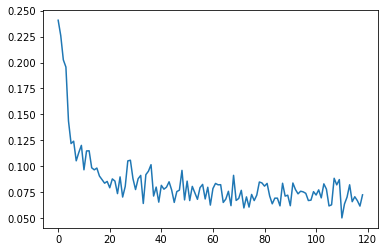

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
torch.save(model.state_dict(), "model_after_train.pt")

plt.plot(all_losses)

In [13]:
test_data = pd.concat([X_test, y_test], axis=1).reset_index()

total = len(test_data)
number_right = 0
model.eval()
with torch.no_grad():
    for idx, row in test_data.iterrows():
        text_parts = preprocess_text(str(row['text']))
        label = torch.tensor([row['fake']]).float().to(device)
        
        overall_output = torch.zeros((1,2)).to(device)
        try:
            for part in text_parts:
                if len(part) > 0:
                    overall_output += model(part.reshape(1, -1))[0]
        except RuntimeError:
            print("GPU out of memory, skipping this entry.")
            continue
            
        overall_output = F.softmax(overall_output[0], dim=-1)
            
        result = overall_output.max(0)[1].float().item()
 
        if result == label.item():
            number_right += 1
            
        if idx % print_every == 0 and idx > 0:
            print("{}/{}. Current accuracy: {}".format(idx, total, number_right / idx))
            
print("Accuracy on test data: {}".format(number_right / total))

300/8980. Current accuracy: 0.95
600/8980. Current accuracy: 0.94
900/8980. Current accuracy: 0.9488888888888889
1200/8980. Current accuracy: 0.9458333333333333
1500/8980. Current accuracy: 0.9433333333333334
1800/8980. Current accuracy: 0.9455555555555556
2100/8980. Current accuracy: 0.9495238095238095
2400/8980. Current accuracy: 0.94875
2700/8980. Current accuracy: 0.9518518518518518
3000/8980. Current accuracy: 0.9523333333333334
3300/8980. Current accuracy: 0.9527272727272728
3600/8980. Current accuracy: 0.9516666666666667
3900/8980. Current accuracy: 0.9517948717948718
4200/8980. Current accuracy: 0.9523809523809523
4500/8980. Current accuracy: 0.9531111111111111
4800/8980. Current accuracy: 0.953125
5100/8980. Current accuracy: 0.9529411764705882
5400/8980. Current accuracy: 0.9531481481481482
5700/8980. Current accuracy: 0.9529824561403509
6000/8980. Current accuracy: 0.9528333333333333
6300/8980. Current accuracy: 0.9531746031746032
6600/8980. Current accuracy: 0.9525757575757